[0, 90, 89, 88, 87, 85, 86, 82, 84, 83, 17, 18, 20, 21, 23, 77, 24, 25, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 68, 69, 67, 64, 66, 63, 61, 62, 60, 48, 58, 57, 54, 53, 52, 36]
Better path found, cost = 296719.0626097001
iteration: 0
Better path found, cost = 296719.0626097
iteration: 1
Better path found, cost = 296719.06260770006
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
[0, 90, 89, 88, 87, 85, 86, 82, 84, 83, 17, 18, 20, 21, 23, 77, 24, 25, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 69, 68, 67, 66, 64, 63, 61, 62, 60, 48, 58, 57, 52, 53, 54, 36]
total distance: 296719.06260770006


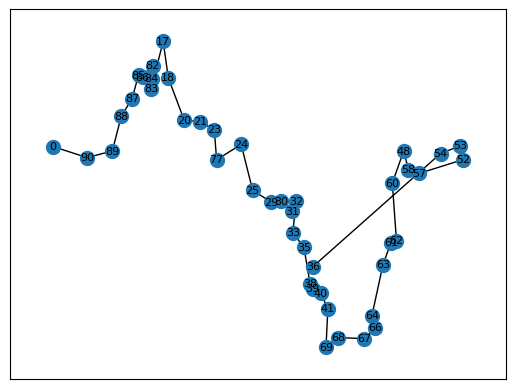

In [1]:
#import libraries
import matplotlib as pl
import pandas as pd
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import networkx as nx
import random

#import the csv file
nodes_df = pd.read_csv("./nodes.csv", encoding='cp1252')
arcs_df = pd.read_csv("./OD.csv")

#define the set of nodes
N = set()
for index, node in nodes_df.iterrows():
    N.add(node.tourist_dest_id)

n = len(N)

def d(i, j):
    if i == j: return 0
    res = arcs_df.loc[(arcs_df['origin_id'] == i) & (arcs_df['destination_id'] == j), 'distance [m]'].values[0]
    return res

def c(i, j):
    return nodes_df.loc[(nodes_df['tourist_dest_id'] == j), 'Cost_of_installation [€]'].values[0]

#define the set of edges
A = set()
for idx, arc in arcs_df.iterrows():
    i = int(arc.origin_id)
    j = int(arc.destination_id)
    if i < j: A.add((i, j))
    
A_weighted = [(i, j, {'weight': d(i, j)}) for i, j in A]


## cost of a path
def cost(path):
    path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    return sum(d(i, j) for i, j in path_edges)

# generate a random neighbor
def random_permutate(path):
    (i, j) = random.sample(path, k=2)
    new_path = path[:]
    idx_i, idx_j = new_path.index(i), new_path.index(j)
    new_path[idx_i], new_path[idx_j] = new_path[idx_j], new_path[idx_i]
    return new_path

# local search algorithm
def neighborhood(path, n_neighbors=100):
    neighbors = []
    for i in range(n_neighbors):
        neighbors.append(random_permutate(path))

    best_neighbor_i = np.argmin([cost(neighbor) for neighbor in neighbors])
    return neighbors[best_neighbor_i]

# execute the local search algorithm and plot the graph/path
def generate_path(initial_path, rounds=10, neighbors_per_round=10):
    path = initial_path[:]
    t = 0
    sigma_path = neighborhood(path, n_neighbors=neighbors_per_round)
    while t < rounds:
        if cost(sigma_path) < cost(path):
            path = sigma_path
            print(f"Better path found, cost = {cost(path)}")

        sigma_path = neighborhood(path, n_neighbors=neighbors_per_round)
        print(f"iteration: {t}")
        t += 1
    return path

# find the greedy path (look at the closest node at every iteration, starting from node 0)
def greedy_path():
    path = [0]
    i = 0
    still_to_choose = list(N)
    still_to_choose.remove(0)
    while len(path) < len(N):
        dists = [d(n, path[i]) for n in still_to_choose]
        i_star = np.argmin(dists)
        path.append(still_to_choose[i_star])
        still_to_choose.pop(i_star)
        i += 1

    return path

#plot the graph
G = nx.Graph()
G.add_nodes_from(N)
G.add_edges_from(A_weighted)

print(greedy_path())
tsp = nx.approximation.traveling_salesman_problem
#greedy_nx = tsp(G, cycle=False, method=nx.approximation.greedy_tsp)
#print(greedy_path() == greedy_nx)

# generate path
path = generate_path(initial_path=greedy_path(), rounds=10, neighbors_per_round=500)

pos = {id: (pos_x, pos_y) for id, pos_x, pos_y in nodes_df[['tourist_dest_id', 'x (longitude)', 'y (latitude)']].values}
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_labels(G,pos=pos, font_size=8)

path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
G.add_edges_from(path_edges)

nx.draw_networkx_edges(G, edgelist=path_edges, pos=pos)
print(path)
print('total distance:', cost(path))
